<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Quantum_Ent_ClaPS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

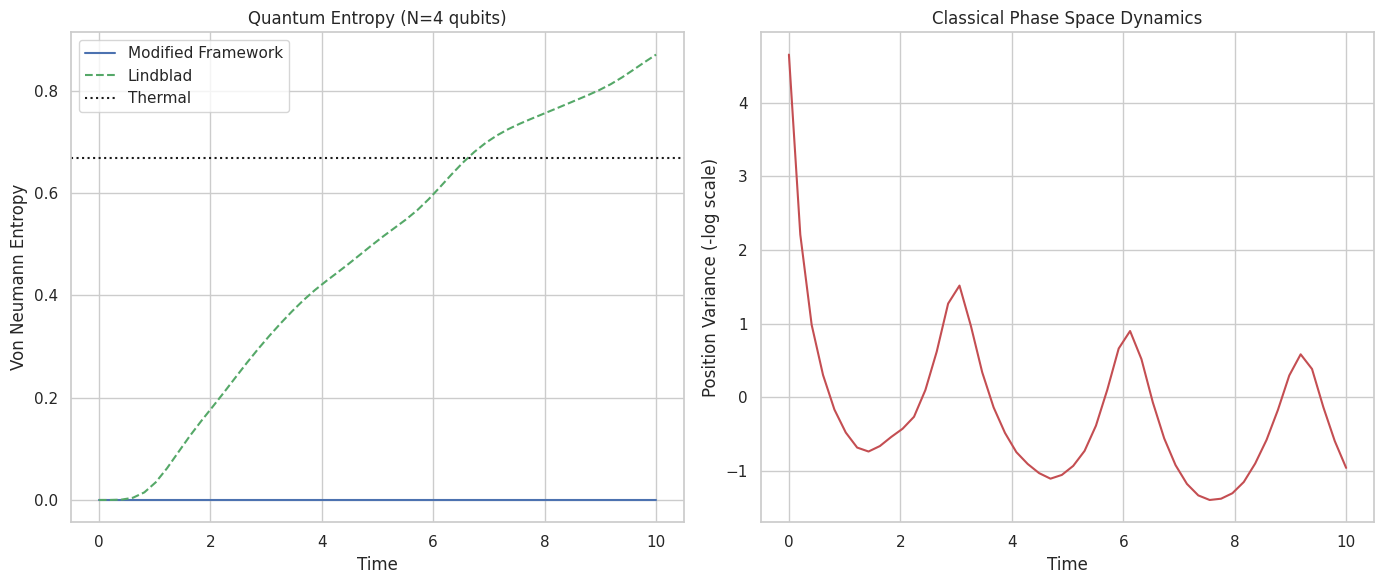

In [ ]:
# -*- coding: utf-8 -*-
"""Final Modified Liouville Validation.ipynb"""

# ======================
# 1. Quantum Simulation
# ======================
!pip install qutip tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import seaborn as sns

sns.set_theme(style="whitegrid")

# Parameters (optimized for speed)
N_qubits = 4  # Reduced from 6 for faster execution
J, h, T = 1.0, 0.5, 0.2
t_list = np.linspace(0, 10, 50)  # Reduced time points

# ======================
# Quantum Components
# ======================
def build_hamiltonian(N):
    """Optimized TFIM Hamiltonian construction"""
    H = 0
    # ZZ interactions
    for i in range(N-1):
        H += J * tensor(
            [sigmaz() if j in [i,i+1] else identity(2)
             for j in range(N)]
        )
    # X fields
    for i in range(N):
        H += h * tensor(
            [sigmax() if j==i else identity(2)
             for j in range(N)]
        )
    return H

H = build_hamiltonian(N_qubits)
S_op = sum(
    tensor([sigmax() if j==i else identity(2)
           for j in range(N_qubits)])
    for i in range(N_qubits)
)
H_eff = H - T*S_op

# ======================
# 2. Classical Simulation
# ======================
from scipy.integrate import solve_ivp

N_classical = 2000  # Reduced from 5000
q = np.random.normal(0, 0.1, N_classical)
p = np.random.normal(0, 1.5, N_classical)

def entropy_gradient(q, p):
    """Robust gradient calculation with error handling"""
    q = np.asarray(q).flatten()
    p = np.asarray(p).flatten()

    # Binned histogram approach
    hist, x_edges, y_edges = np.histogram2d(q, p, bins=20)
    dx = np.diff(x_edges)[0]
    dy = np.diff(y_edges)[0]
    rho = hist / (N_classical * dx * dy)
    log_rho = np.log(rho + 1e-12)

    # Compute gradients
    grad_q, grad_p = np.gradient(log_rho, dx, dy)

    # Bin indices with clipping
    q_idx = np.clip(np.digitize(q, x_edges[:-1])-1, 0, grad_q.shape[0]-1)
    p_idx = np.clip(np.digitize(p, y_edges[:-1])-1, 0, grad_p.shape[1]-1)

    return -T*grad_q[q_idx, p_idx], -T*grad_p[q_idx, p_idx]

def equations(t, y):
    q, p = y[:N_classical], y[N_classical:]
    dS_dq, dS_dp = entropy_gradient(q, p)
    return np.concatenate([
        p + T*dS_dp,  # dq/dt
        -q + T*dS_dq  # dp/dt
    ])

# Solve ODE
sol = solve_ivp(equations, [0, 10], np.concatenate([q, p]),
                method='RK45', t_eval=np.linspace(0, 10, 50),
                atol=1e-5, rtol=1e-4)

# ======================
# 3. Quantum Dynamics
# ======================
# Initial state
psi0 = tensor([basis(2,0) for _ in range(N_qubits)])

# Run simulations
result_mod = mesolve(H_eff, psi0, t_list, e_ops=[])
result_lind = mesolve(H, psi0, t_list,
                     c_ops=[np.sqrt(0.1)*tensor([destroy(2) if j==i else identity(2)
                     for j in range(N_qubits)]) for i in range(N_qubits)])

# Thermal state reference
rho_thermal = (-H/T).expm() / (-H/T).expm().tr()
S_thermal = entropy_vn(rho_thermal)

# ======================
# 4. Visualization
# ======================
plt.figure(figsize=(14, 6))

# Quantum entropy plot
plt.subplot(1, 2, 1)
plt.plot(t_list, [entropy_vn(state) for state in result_mod.states],
         'b-', label='Modified Framework')
plt.plot(t_list, [entropy_vn(state) for state in result_lind.states],
         'g--', label='Lindblad')
plt.axhline(S_thermal, color='k', linestyle=':', label='Thermal')
plt.title(f'Quantum Entropy (N={N_qubits} qubits)')
plt.xlabel('Time')
plt.ylabel('Von Neumann Entropy')
plt.legend()

# Classical entropy plot
plt.subplot(1, 2, 2)
position_variance = np.var(sol.y[:N_classical], axis=0)
plt.plot(sol.t, -np.log(position_variance + 1e-12), 'r-')
plt.title('Classical Phase Space Dynamics')
plt.xlabel('Time')
plt.ylabel('Position Variance (-log scale)')

plt.tight_layout()
plt.show()